https://zhuanlan.zhihu.com/p/435945714

In [1]:
import torch
from torch import nn, Tensor, optim
from torch.nn import functional as F
from torch_geometric import nn as gnn
from torch_geometric import datasets
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric import transforms as gtransforms
from torch_geometric.utils import to_networkx
import networkx as nx
from tqdm import tqdm
from plotly import express as px
from plotly import graph_objects as go
import matplotlib.pyplot as plt

In [2]:
device = (
    "cuda:0"
    if torch.cuda.is_available()
    else ("mps" if torch.backends.mps.is_available() else "cpu")
)
device

'cuda:0'

In [3]:
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# torch_geometric.data.Data

节点和节点之间的边构成了图。所以在 PyG 中，如果你要构建图，那么需要两个要素：节点和边。PyG 提供了torch_geometric.data.Data (下面简称Data) 用于构建图，包括 5 个属性，每一个属性都不是必须的，可以为空。

- x: 用于存储每个节点的特征，形状是 `[num_nodes, num_node_features]`
- y: 存储样本标签。如果是每个节点都有标签，那么形状是 `[num_nodes, *]`；如果是整张图只有一个标签，那么形状是 `[1, *]`
- edge_index: 用于存储节点之间的边，形状是 `[2, num_edges]`
- pos: 存储节点的坐标，形状是 `[num_nodes, num_dimensions]`
- edge_attr: 存储边的特征。形状是 `[num_edges, num_edge_features]`

In [4]:
# x: 用于存储每个节点的特征，形状是 `[num_nodes, num_node_features]`。
x = torch.tensor([[2, 1], [5, 6], [3, 7], [12, 0]], dtype=torch.float)
x

tensor([[ 2.,  1.],
        [ 5.,  6.],
        [ 3.,  7.],
        [12.,  0.]])

In [5]:
# y: 存储样本标签。如果是每个节点都有标签，那么形状是 `[num_nodes, *]`；如果是整张图只有一个标签，那么形状是 `[1, *]`。
y = torch.tensor([[0], [2], [3], [4]], dtype=torch.long)
y

tensor([[0],
        [2],
        [3],
        [4]])

In [6]:
# edge_index: 用于存储节点之间的边，形状是 `[2, num_edges]`
# 5条边: (0 -> 1), (0 -> 2), (1 -> 2), (1 -> 3), (2 -> 3)
edge_index = torch.tensor(
    [[0, 1, 0, 1, 1, 2, 3], [1, 0, 2, 2, 3, 3, 2]], dtype=torch.long
)
edge_index

tensor([[0, 1, 0, 1, 1, 2, 3],
        [1, 0, 2, 2, 3, 3, 2]])

In [7]:
data = Data(x=x, y=y, edge_index=edge_index)
data

Data(x=[4, 2], edge_index=[2, 7], y=[4, 1])

In [ ]:
for i in data:
    print(i)

('x', tensor([[ 2.,  1.],
        [ 5.,  6.],
        [ 3.,  7.],
        [12.,  0.]]))
('edge_index', tensor([[0, 1, 0, 1, 1, 2, 3],
        [1, 0, 2, 2, 3, 3, 2]]))
('y', tensor([[0],
        [2],
        [3],
        [4]]))


In [9]:
def visualize_graph(G, color):
    plt.figure(figsize=(7, 7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(
        G,
        pos=nx.spring_layout(G, seed=42),
        with_labels=False,
        node_color=color,
        cmap="Set2",
    )
    plt.show()

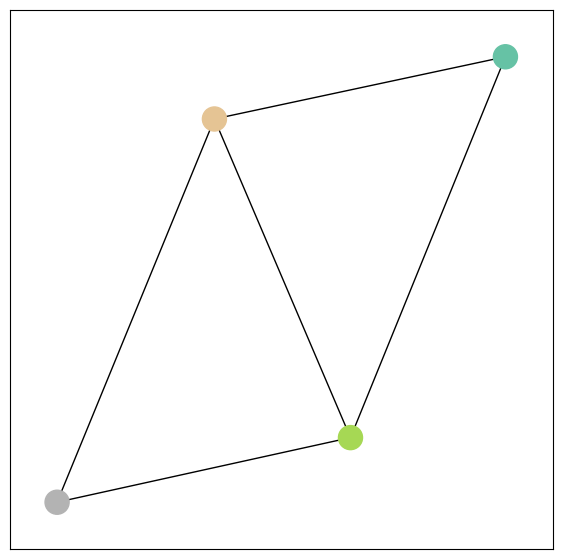

In [10]:
visualize_graph(to_networkx(data, to_undirected=True), color=data.y)

# from torch_geometric.datasets

In [11]:
transform = gtransforms.Compose(
    [
        gtransforms.NormalizeFeatures(),
    ]
)
transform

Compose([
  NormalizeFeatures()
])

| Name          | #graphs | #nodes | #edges  | #features | #classes |
| ------------- | ------- | ------ | ------- | --------- | -------- |
| MUTAG         | 188     | ~17.9  | ~39.6   | 7         | 2        |
| ENZYMES       | 600     | ~32.6  | ~124.3  | 3         | 6        |
| PROTEINS      | 1,113   | ~39.1  | ~145.6  | 3         | 2        |
| COLLAB        | 5,000   | ~74.5  | ~4914.4 | 0         | 3        |
| IMDB-BINARY   | 1,000   | ~19.8  | ~193.1  | 0         | 2        |
| REDDIT-BINARY | 2,000   | ~429.6 | ~995.5  | 0         | 2        |

In [12]:
dataset = datasets.TUDataset(
    root="./datasets/TUDataset",
    name="PROTEINS",  # MUTAG, ENZYMES, PROTEINS, COLLAB, IMDB-BINARY, REDDIT-BINARY
    transform=transform,
    use_node_attr=True,
)
dataset[0]

Data(edge_index=[2, 162], x=[42, 4], y=[1])

In [13]:
dataset = dataset.shuffle()
dataset[0]

Data(edge_index=[2, 122], x=[31, 4], y=[1])

In [14]:
dataset.num_edge_attributes, dataset.num_edge_features, dataset.num_edge_labels

(0, 0, 0)

In [15]:
dataset.num_node_attributes, dataset.num_node_features, dataset.num_edge_labels

(1, 4, 0)

In [16]:
dataset.num_features, dataset.num_classes

(4, 2)

In [17]:
val_ratio = 0.2
dataset_len = len(dataset)
print(dataset_len)
val_dataset_len = int(dataset_len * val_ratio)
print(dataset_len - val_dataset_len)
print(val_dataset_len)

1113
891
222


In [18]:
train_dataset = dataset[:-val_dataset_len]
print(len(train_dataset))
val_dataset = dataset[-val_dataset_len:]
print(len(val_dataset))

891
222


In [19]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=2, shuffle=True)
train_dataloader

In [20]:
val_dataloader = DataLoader(dataset=val_dataset, batch_size=2, shuffle=False)
val_dataloader

In [21]:
for i, batch in enumerate(train_dataloader):
    print(batch)
    print(
        "x: \t\t", batch.x.shape
    )  # [batch_sum, num_features] 图的每一条数据的长度不一定相等,batch_sum代表这个batch中的全部节点数据
    print("edge_index: \t", batch.edge_index.shape)  # 代表边的连接
    print(
        "batch: \t\t", batch.batch.shape
    )  # batch代表是这个batch中哪一些数据是一组的. 0为1组,1为1组...
    # print("batch: \t\t",    batch.batch)
    print("y: \t\t", batch.y.shape)  # 类别
    print("y: \t\t", y)
    if i >= 5:
        break

DataBatch(edge_index=[2, 528], x=[150, 4], y=[2], batch=[150], ptr=[3])
x: 		 torch.Size([150, 4])
edge_index: 	 torch.Size([2, 528])
batch: 		 torch.Size([150])
y: 		 torch.Size([2])
y: 		 tensor([[0],
        [2],
        [3],
        [4]])
DataBatch(edge_index=[2, 174], x=[50, 4], y=[2], batch=[50], ptr=[3])
x: 		 torch.Size([50, 4])
edge_index: 	 torch.Size([2, 174])
batch: 		 torch.Size([50])
y: 		 torch.Size([2])
y: 		 tensor([[0],
        [2],
        [3],
        [4]])
DataBatch(edge_index=[2, 386], x=[96, 4], y=[2], batch=[96], ptr=[3])
x: 		 torch.Size([96, 4])
edge_index: 	 torch.Size([2, 386])
batch: 		 torch.Size([96])
y: 		 torch.Size([2])
y: 		 tensor([[0],
        [2],
        [3],
        [4]])
DataBatch(edge_index=[2, 262], x=[64, 4], y=[2], batch=[64], ptr=[3])
x: 		 torch.Size([64, 4])
edge_index: 	 torch.Size([2, 262])
batch: 		 torch.Size([64])
y: 		 torch.Size([2])
y: 		 tensor([[0],
        [2],
        [3],
        [4]])
DataBatch(edge_index=[2, 242], x=[76, 4]

In [22]:
batch.x.shape

torch.Size([41, 4])

# Model

In [23]:
class Net(nn.Module):
    def __init__(
        self,
        conv: nn.Module = gnn.GraphConv,  # [GraphConv, GCNConv, SAGEConv, GATConv]
        norm: nn.Module = nn.BatchNorm1d,  # [BatchNorm1d, LayerNorm, InstanceNorm1d]
        act: nn.Module = nn.ReLU,
    ) -> None:
        super().__init__()
        self.conv1 = conv(in_channels=dataset.num_features, out_channels=64)
        self.norm1 = norm(64)
        self.act1 = act()

        self.conv2 = conv(in_channels=64, out_channels=64)
        self.norm2 = norm(64)
        self.act2 = act()

        self.conv3 = conv(in_channels=64, out_channels=64)
        self.norm3 = norm(64)
        self.act3 = act()

        self.fc = nn.Linear(in_features=64, out_features=dataset.num_classes)

    def forward(self, x: Tensor, edge_index: Tensor, batch: Tensor = None) -> Tensor:
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = self.act1(x)

        res = x
        x = self.conv2(x, edge_index)
        x = self.norm2(x)
        x = self.act2(x)
        x = x + res

        res = x
        x = self.conv3(x, edge_index)
        x = self.norm3(x)
        x = self.act3(x)
        x = x + res

        # global_max_pool: 将节点嵌入聚合到一个统一的图嵌入(readout layer)中
        x = gnn.global_max_pool(
            x, batch
        )  # [batch_sum, num_features] -> [batch, num_features]

        x = self.fc(x)
        return x

In [24]:
net = Net().to(device)
net

Net(
  (conv1): GraphConv(4, 64)
  (norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU()
  (conv2): GraphConv(64, 64)
  (norm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU()
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

In [25]:
optimizer = optim.Adam(params=net.parameters())
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [26]:
epochs = 100

In [27]:
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer=optimizer,
    T_max=epochs,
    eta_min=optimizer.state_dict()["param_groups"][0]["lr"] * 0.01,
)
lr_scheduler

In [28]:
loss_fn = nn.CrossEntropyLoss()
loss_fn

CrossEntropyLoss()

# train

In [29]:
train_accuracies = []
train_lossess = []
val_accuracies = []
val_lossess = []
for epoch in range(1, epochs + 1):
    net.train()
    train_y_trues = []
    train_y_preds = []
    train_losses = []
    pbar = tqdm(total=len(train_dataloader), desc=f"train-epoch: {epoch}")
    for batch in train_dataloader:
        optimizer.zero_grad()
        x, edge_index, batch, y = batch.x, batch.edge_index, batch.batch, batch.y
        x, edge_index, batch, y = (
            x.to(device),
            edge_index.to(device),
            batch.to(device),
            y.to(device),
        )
        y_pred = net(x, edge_index, batch)
        loss: Tensor = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()

        train_y_trues.append(y)
        train_y_preds.append(y_pred.argmax(dim=-1))
        train_losses.append(loss.item())
        pbar.update(1)
        pbar.set_postfix({"loss": loss.item()})
    pbar.close()

    lr_scheduler.step()

    # 准确率
    train_y_trues_ = torch.cat(train_y_trues)
    train_y_preds_ = torch.cat(train_y_preds)
    train_accuracy = (
        (train_y_trues_ == train_y_preds_).float().sum().divide(len(train_y_trues_))
    )
    train_accuracies.append(train_accuracy.item())
    train_lossess.append(torch.tensor(train_losses).mean().item())

    net.eval()
    val_y_trues = []
    val_y_preds = []
    val_losses = []
    pbar = tqdm(total=len(val_dataloader), desc=f"val-epoch: {epoch}")
    for batch in val_dataloader:
        x, edge_index, batch, y = batch.x, batch.edge_index, batch.batch, batch.y
        x, edge_index, batch, y = (
            x.to(device),
            edge_index.to(device),
            batch.to(device),
            y.to(device),
        )
        with torch.inference_mode():
            y_pred = net(x, edge_index, batch)
        loss: Tensor = loss_fn(y_pred, y)

        val_y_trues.append(y)
        val_y_preds.append(y_pred.argmax(dim=-1))
        val_losses.append(loss.item())
        pbar.update(1)
        pbar.set_postfix({"loss": loss.item()})
    pbar.close()

    # 准确率
    val_y_trues_ = torch.cat(val_y_trues)
    val_y_preds_ = torch.cat(val_y_preds)
    val_accuracy = (
        (val_y_trues_ == val_y_preds_).float().sum().divide(len(val_y_trues_))
    )
    val_accuracies.append(val_accuracy.item())
    val_lossess.append(torch.tensor(val_losses).mean().item())

    print(
        f"\033[0;31;40mepoch: {epoch}\033[0m "
        + f"\033[0;32;40mtrain_accuracy = {train_accuracy.item()}\033[0m "
        + f"\033[0;34;40mval_accuracy = {val_accuracy.item()}\033[0m"
    )

val-epoch: 1: 100%|██████████| 111/111 [00:04<00:00, 25.99it/s, loss=0.513]


epoch: 1 train_accuracy = 0.6217733025550842 val_accuracy = 0.6936936974525452


val-epoch: 2: 100%|██████████| 111/111 [00:04<00:00, 25.73it/s, loss=0.158] 


epoch: 2 train_accuracy = 0.6677890419960022 val_accuracy = 0.7027027010917664


val-epoch: 3: 100%|██████████| 111/111 [00:04<00:00, 26.55it/s, loss=0.723]


epoch: 3 train_accuracy = 0.7070707678794861 val_accuracy = 0.5765765905380249


val-epoch: 4: 100%|██████████| 111/111 [00:04<00:00, 25.20it/s, loss=0.378]


epoch: 4 train_accuracy = 0.7014590501785278 val_accuracy = 0.7522522807121277


val-epoch: 5: 100%|██████████| 111/111 [00:04<00:00, 26.14it/s, loss=0.987]


epoch: 5 train_accuracy = 0.711560070514679 val_accuracy = 0.5720720887184143


val-epoch: 6: 100%|██████████| 111/111 [00:04<00:00, 25.53it/s, loss=0.196]


epoch: 6 train_accuracy = 0.7351291179656982 val_accuracy = 0.7612612843513489


val-epoch: 7: 100%|██████████| 111/111 [00:04<00:00, 25.54it/s, loss=0.248] 


epoch: 7 train_accuracy = 0.7351291179656982 val_accuracy = 0.7432432770729065


val-epoch: 8: 100%|██████████| 111/111 [00:04<00:00, 26.18it/s, loss=0.0746]


epoch: 8 train_accuracy = 0.7396184206008911 val_accuracy = 0.7612612843513489


val-epoch: 9: 100%|██████████| 111/111 [00:04<00:00, 24.17it/s, loss=0.365]


epoch: 9 train_accuracy = 0.7362514138221741 val_accuracy = 0.7612612843513489


val-epoch: 10: 100%|██████████| 111/111 [00:04<00:00, 25.65it/s, loss=0.178] 


epoch: 10 train_accuracy = 0.7620651125907898 val_accuracy = 0.7612612843513489


val-epoch: 11: 100%|██████████| 111/111 [00:00<00:00, 134.01it/s, loss=0.291] 


epoch: 11 train_accuracy = 0.767676830291748 val_accuracy = 0.7297297716140747


val-epoch: 12: 100%|██████████| 111/111 [00:00<00:00, 157.44it/s, loss=0.0446]


epoch: 12 train_accuracy = 0.7620651125907898 val_accuracy = 0.7117117047309875


val-epoch: 13: 100%|██████████| 111/111 [00:00<00:00, 175.36it/s, loss=0.121] 


epoch: 13 train_accuracy = 0.7631874680519104 val_accuracy = 0.7657657861709595


val-epoch: 14: 100%|██████████| 111/111 [00:04<00:00, 25.88it/s, loss=0.111] 


epoch: 14 train_accuracy = 0.7811447978019714 val_accuracy = 0.7342342734336853


val-epoch: 15: 100%|██████████| 111/111 [00:04<00:00, 26.94it/s, loss=0.153] 


epoch: 15 train_accuracy = 0.8024691939353943 val_accuracy = 0.7432432770729065


val-epoch: 16: 100%|██████████| 111/111 [00:04<00:00, 26.26it/s, loss=0.062] 


epoch: 16 train_accuracy = 0.7833895087242126 val_accuracy = 0.7342342734336853


val-epoch: 17: 100%|██████████| 111/111 [00:04<00:00, 26.77it/s, loss=0.0617]


epoch: 17 train_accuracy = 0.8103255033493042 val_accuracy = 0.7567567825317383


val-epoch: 18: 100%|██████████| 111/111 [00:04<00:00, 25.67it/s, loss=0.0815]


epoch: 18 train_accuracy = 0.8047138452529907 val_accuracy = 0.7162162065505981


val-epoch: 19: 100%|██████████| 111/111 [00:04<00:00, 25.83it/s, loss=0.0937]


epoch: 19 train_accuracy = 0.8058362007141113 val_accuracy = 0.6576576828956604


val-epoch: 20: 100%|██████████| 111/111 [00:04<00:00, 25.44it/s, loss=0.179] 


epoch: 20 train_accuracy = 0.8181818723678589 val_accuracy = 0.7522522807121277


val-epoch: 21: 100%|██████████| 111/111 [00:04<00:00, 25.19it/s, loss=0.0526] 


epoch: 21 train_accuracy = 0.8350168466567993 val_accuracy = 0.7387387752532959


val-epoch: 22: 100%|██████████| 111/111 [00:04<00:00, 25.87it/s, loss=0.0287] 


epoch: 22 train_accuracy = 0.8215488791465759 val_accuracy = 0.7567567825317383


val-epoch: 23: 100%|██████████| 111/111 [00:04<00:00, 25.81it/s, loss=0.0356]


epoch: 23 train_accuracy = 0.8069584965705872 val_accuracy = 0.7432432770729065


val-epoch: 24: 100%|██████████| 111/111 [00:04<00:00, 26.72it/s, loss=0.063] 


epoch: 24 train_accuracy = 0.8473625779151917 val_accuracy = 0.7477477788925171


val-epoch: 25: 100%|██████████| 111/111 [00:04<00:00, 24.91it/s, loss=0.149] 


epoch: 25 train_accuracy = 0.8473625779151917 val_accuracy = 0.7252252697944641


val-epoch: 26: 100%|██████████| 111/111 [00:04<00:00, 26.06it/s, loss=0.0563] 


epoch: 26 train_accuracy = 0.8451178669929504 val_accuracy = 0.7207207679748535


val-epoch: 27: 100%|██████████| 111/111 [00:04<00:00, 26.13it/s, loss=0.018] 


epoch: 27 train_accuracy = 0.8294051885604858 val_accuracy = 0.6981981992721558


val-epoch: 28: 100%|██████████| 111/111 [00:04<00:00, 26.94it/s, loss=0.0105] 


epoch: 28 train_accuracy = 0.839506208896637 val_accuracy = 0.7387387752532959


val-epoch: 29: 100%|██████████| 111/111 [00:04<00:00, 24.80it/s, loss=0.0413]


epoch: 29 train_accuracy = 0.8406285643577576 val_accuracy = 0.7477477788925171


val-epoch: 30: 100%|██████████| 111/111 [00:04<00:00, 25.78it/s, loss=0.0149]


epoch: 30 train_accuracy = 0.8316498398780823 val_accuracy = 0.7252252697944641


val-epoch: 31: 100%|██████████| 111/111 [00:04<00:00, 25.29it/s, loss=0.0215]


epoch: 31 train_accuracy = 0.8518518805503845 val_accuracy = 0.7387387752532959


val-epoch: 32: 100%|██████████| 111/111 [00:02<00:00, 44.01it/s, loss=0.0465] 


epoch: 32 train_accuracy = 0.8619529008865356 val_accuracy = 0.7432432770729065


val-epoch: 33: 100%|██████████| 111/111 [00:04<00:00, 25.58it/s, loss=0.104]  


epoch: 33 train_accuracy = 0.8597082495689392 val_accuracy = 0.7432432770729065


val-epoch: 34: 100%|██████████| 111/111 [00:04<00:00, 25.90it/s, loss=0.0533]


epoch: 34 train_accuracy = 0.8720539212226868 val_accuracy = 0.707207202911377


val-epoch: 35: 100%|██████████| 111/111 [00:04<00:00, 25.64it/s, loss=0.0368] 


epoch: 35 train_accuracy = 0.8754209280014038 val_accuracy = 0.7567567825317383


val-epoch: 36: 100%|██████████| 111/111 [00:04<00:00, 25.42it/s, loss=0.00477] 


epoch: 36 train_accuracy = 0.8832772374153137 val_accuracy = 0.7432432770729065


val-epoch: 37: 100%|██████████| 111/111 [00:04<00:00, 26.68it/s, loss=0.00831]


epoch: 37 train_accuracy = 0.8911336064338684 val_accuracy = 0.7342342734336853


val-epoch: 38: 100%|██████████| 111/111 [00:04<00:00, 23.98it/s, loss=0.0316] 


epoch: 38 train_accuracy = 0.8832772374153137 val_accuracy = 0.7387387752532959


val-epoch: 39: 100%|██████████| 111/111 [00:04<00:00, 25.47it/s, loss=0.0428] 


epoch: 39 train_accuracy = 0.8956229090690613 val_accuracy = 0.7477477788925171


val-epoch: 40: 100%|██████████| 111/111 [00:04<00:00, 25.93it/s, loss=0.0216]


epoch: 40 train_accuracy = 0.888888955116272 val_accuracy = 0.7432432770729065


val-epoch: 41: 100%|██████████| 111/111 [00:04<00:00, 25.29it/s, loss=0.029]  


epoch: 41 train_accuracy = 0.8911336064338684 val_accuracy = 0.7432432770729065


val-epoch: 42: 100%|██████████| 111/111 [00:04<00:00, 26.23it/s, loss=0.0395] 


epoch: 42 train_accuracy = 0.892255961894989 val_accuracy = 0.7612612843513489


val-epoch: 43: 100%|██████████| 111/111 [00:04<00:00, 24.78it/s, loss=0.116] 


epoch: 43 train_accuracy = 0.8855219483375549 val_accuracy = 0.6981981992721558


val-epoch: 44: 100%|██████████| 111/111 [00:04<00:00, 25.59it/s, loss=0.101]  


epoch: 44 train_accuracy = 0.8945006132125854 val_accuracy = 0.7297297716140747


val-epoch: 45: 100%|██████████| 111/111 [00:04<00:00, 25.52it/s, loss=0.0374] 


epoch: 45 train_accuracy = 0.906846284866333 val_accuracy = 0.7252252697944641


val-epoch: 46: 100%|██████████| 111/111 [00:04<00:00, 26.94it/s, loss=0.0695]  


epoch: 46 train_accuracy = 0.8978676199913025 val_accuracy = 0.7522522807121277


val-epoch: 47: 100%|██████████| 111/111 [00:04<00:00, 27.42it/s, loss=0.101]  


epoch: 47 train_accuracy = 0.9046016335487366 val_accuracy = 0.707207202911377


val-epoch: 48: 100%|██████████| 111/111 [00:04<00:00, 25.59it/s, loss=0.0484]


epoch: 48 train_accuracy = 0.9147025942802429 val_accuracy = 0.7702702879905701


val-epoch: 49: 100%|██████████| 111/111 [00:04<00:00, 25.48it/s, loss=0.0186] 


epoch: 49 train_accuracy = 0.9090909361839294 val_accuracy = 0.7432432770729065


val-epoch: 50: 100%|██████████| 111/111 [00:04<00:00, 24.57it/s, loss=0.0186] 


epoch: 50 train_accuracy = 0.9147025942802429 val_accuracy = 0.7342342734336853


val-epoch: 51: 100%|██████████| 111/111 [00:04<00:00, 25.49it/s, loss=0.0509]  


epoch: 51 train_accuracy = 0.9225589632987976 val_accuracy = 0.7432432770729065


val-epoch: 52: 100%|██████████| 111/111 [00:04<00:00, 25.25it/s, loss=0.00851]


epoch: 52 train_accuracy = 0.9135802984237671 val_accuracy = 0.7342342734336853


val-epoch: 53: 100%|██████████| 111/111 [00:04<00:00, 26.27it/s, loss=0.011]   


epoch: 53 train_accuracy = 0.91806960105896 val_accuracy = 0.7522522807121277


val-epoch: 54: 100%|██████████| 111/111 [00:04<00:00, 24.96it/s, loss=0.0663] 


epoch: 54 train_accuracy = 0.924803614616394 val_accuracy = 0.7252252697944641


val-epoch: 55: 100%|██████████| 111/111 [00:04<00:00, 26.38it/s, loss=0.0314] 


epoch: 55 train_accuracy = 0.9326599836349487 val_accuracy = 0.7297297716140747


val-epoch: 56: 100%|██████████| 111/111 [00:04<00:00, 25.60it/s, loss=0.151]  


epoch: 56 train_accuracy = 0.9236813187599182 val_accuracy = 0.6891891956329346


val-epoch: 57: 100%|██████████| 111/111 [00:04<00:00, 25.43it/s, loss=0.0258] 


epoch: 57 train_accuracy = 0.9427610039710999 val_accuracy = 0.7432432770729065


val-epoch: 58: 100%|██████████| 111/111 [00:04<00:00, 26.18it/s, loss=0.039]  


epoch: 58 train_accuracy = 0.9270483255386353 val_accuracy = 0.7162162065505981


val-epoch: 59: 100%|██████████| 111/111 [00:04<00:00, 24.82it/s, loss=0.0985] 


epoch: 59 train_accuracy = 0.9292929768562317 val_accuracy = 0.7342342734336853


val-epoch: 60: 100%|██████████| 111/111 [00:04<00:00, 26.65it/s, loss=0.0418] 


epoch: 60 train_accuracy = 0.9382716417312622 val_accuracy = 0.7612612843513489


val-epoch: 61: 100%|██████████| 111/111 [00:04<00:00, 26.04it/s, loss=0.0167]  


epoch: 61 train_accuracy = 0.9393939971923828 val_accuracy = 0.7387387752532959


val-epoch: 62: 100%|██████████| 111/111 [00:04<00:00, 27.04it/s, loss=0.115] 


epoch: 62 train_accuracy = 0.9393939971923828 val_accuracy = 0.7162162065505981


val-epoch: 63: 100%|██████████| 111/111 [00:04<00:00, 27.57it/s, loss=0.0065]  


epoch: 63 train_accuracy = 0.9393939971923828 val_accuracy = 0.7432432770729065


val-epoch: 64: 100%|██████████| 111/111 [00:04<00:00, 26.21it/s, loss=0.024]  


epoch: 64 train_accuracy = 0.9259259700775146 val_accuracy = 0.7342342734336853


val-epoch: 65: 100%|██████████| 111/111 [00:04<00:00, 24.80it/s, loss=0.0115] 


epoch: 65 train_accuracy = 0.9360269904136658 val_accuracy = 0.7207207679748535


val-epoch: 66: 100%|██████████| 111/111 [00:04<00:00, 26.14it/s, loss=0.0172] 


epoch: 66 train_accuracy = 0.9360269904136658 val_accuracy = 0.7387387752532959


val-epoch: 67: 100%|██████████| 111/111 [00:04<00:00, 25.45it/s, loss=0.0806] 


epoch: 67 train_accuracy = 0.952862024307251 val_accuracy = 0.7117117047309875


val-epoch: 68: 100%|██████████| 111/111 [00:04<00:00, 26.80it/s, loss=0.00395] 


epoch: 68 train_accuracy = 0.9326599836349487 val_accuracy = 0.7297297716140747


val-epoch: 69: 100%|██████████| 111/111 [00:04<00:00, 26.05it/s, loss=0.0103] 


epoch: 69 train_accuracy = 0.9595959782600403 val_accuracy = 0.7162162065505981


val-epoch: 70: 100%|██████████| 111/111 [00:04<00:00, 26.60it/s, loss=0.0118] 


epoch: 70 train_accuracy = 0.9551066756248474 val_accuracy = 0.7387387752532959


val-epoch: 71: 100%|██████████| 111/111 [00:04<00:00, 25.66it/s, loss=0.0217] 


epoch: 71 train_accuracy = 0.952862024307251 val_accuracy = 0.7207207679748535


val-epoch: 72: 100%|██████████| 111/111 [00:04<00:00, 26.71it/s, loss=0.0223] 


epoch: 72 train_accuracy = 0.9461280107498169 val_accuracy = 0.7117117047309875


val-epoch: 73: 100%|██████████| 111/111 [00:04<00:00, 26.93it/s, loss=0.00859]


epoch: 73 train_accuracy = 0.9472503066062927 val_accuracy = 0.7342342734336853


val-epoch: 74: 100%|██████████| 111/111 [00:04<00:00, 27.20it/s, loss=0.0218] 


epoch: 74 train_accuracy = 0.9573513269424438 val_accuracy = 0.7252252697944641


val-epoch: 75: 100%|██████████| 111/111 [00:04<00:00, 26.15it/s, loss=0.00796]


epoch: 75 train_accuracy = 0.9595959782600403 val_accuracy = 0.707207202911377


val-epoch: 76: 100%|██████████| 111/111 [00:04<00:00, 26.67it/s, loss=0.0377] 


epoch: 76 train_accuracy = 0.9607183337211609 val_accuracy = 0.7297297716140747


val-epoch: 77: 100%|██████████| 111/111 [00:04<00:00, 25.45it/s, loss=0.02]   


epoch: 77 train_accuracy = 0.9584736824035645 val_accuracy = 0.7207207679748535


val-epoch: 78: 100%|██████████| 111/111 [00:04<00:00, 26.87it/s, loss=0.0313] 


epoch: 78 train_accuracy = 0.9539843201637268 val_accuracy = 0.7297297716140747


val-epoch: 79: 100%|██████████| 111/111 [00:04<00:00, 24.70it/s, loss=0.00428]


epoch: 79 train_accuracy = 0.9573513269424438 val_accuracy = 0.7252252697944641


val-epoch: 80: 100%|██████████| 111/111 [00:04<00:00, 27.10it/s, loss=0.0215] 


epoch: 80 train_accuracy = 0.9696969985961914 val_accuracy = 0.7342342734336853


val-epoch: 81: 100%|██████████| 111/111 [00:04<00:00, 26.40it/s, loss=0.0175]


epoch: 81 train_accuracy = 0.9517396688461304 val_accuracy = 0.7027027010917664


val-epoch: 82: 100%|██████████| 111/111 [00:04<00:00, 26.66it/s, loss=0.0143] 


epoch: 82 train_accuracy = 0.9584736824035645 val_accuracy = 0.7162162065505981


val-epoch: 83: 100%|██████████| 111/111 [00:04<00:00, 26.65it/s, loss=0.0151] 


epoch: 83 train_accuracy = 0.9573513269424438 val_accuracy = 0.7342342734336853


val-epoch: 84: 100%|██████████| 111/111 [00:04<00:00, 26.59it/s, loss=0.0143]  


epoch: 84 train_accuracy = 0.9494950175285339 val_accuracy = 0.7207207679748535


val-epoch: 85: 100%|██████████| 111/111 [00:04<00:00, 25.94it/s, loss=0.0139] 


epoch: 85 train_accuracy = 0.9640853404998779 val_accuracy = 0.7207207679748535


val-epoch: 86: 100%|██████████| 111/111 [00:04<00:00, 25.28it/s, loss=0.00969] 


epoch: 86 train_accuracy = 0.9539843201637268 val_accuracy = 0.7387387752532959


val-epoch: 87: 100%|██████████| 111/111 [00:04<00:00, 26.59it/s, loss=0.0214] 


epoch: 87 train_accuracy = 0.9652076959609985 val_accuracy = 0.7342342734336853


val-epoch: 88: 100%|██████████| 111/111 [00:04<00:00, 25.92it/s, loss=0.0201] 


epoch: 88 train_accuracy = 0.9595959782600403 val_accuracy = 0.7342342734336853


val-epoch: 89: 100%|██████████| 111/111 [00:00<00:00, 182.85it/s, loss=0.0176] 


epoch: 89 train_accuracy = 0.9539843201637268 val_accuracy = 0.7252252697944641


val-epoch: 90: 100%|██████████| 111/111 [00:04<00:00, 26.24it/s, loss=0.0261] 


epoch: 90 train_accuracy = 0.9595959782600403 val_accuracy = 0.7207207679748535


val-epoch: 91: 100%|██████████| 111/111 [00:04<00:00, 25.43it/s, loss=0.0411] 


epoch: 91 train_accuracy = 0.952862024307251 val_accuracy = 0.7162162065505981


val-epoch: 92: 100%|██████████| 111/111 [00:04<00:00, 26.79it/s, loss=0.02]   


epoch: 92 train_accuracy = 0.9764310121536255 val_accuracy = 0.7342342734336853


val-epoch: 93: 100%|██████████| 111/111 [00:04<00:00, 25.51it/s, loss=0.0166]  


epoch: 93 train_accuracy = 0.967452347278595 val_accuracy = 0.7252252697944641


val-epoch: 94: 100%|██████████| 111/111 [00:04<00:00, 26.90it/s, loss=0.0114] 


epoch: 94 train_accuracy = 0.9607183337211609 val_accuracy = 0.7207207679748535


val-epoch: 95: 100%|██████████| 111/111 [00:04<00:00, 25.86it/s, loss=0.021]  


epoch: 95 train_accuracy = 0.952862024307251 val_accuracy = 0.7207207679748535


val-epoch: 96: 100%|██████████| 111/111 [00:04<00:00, 25.80it/s, loss=0.0249]  


epoch: 96 train_accuracy = 0.9640853404998779 val_accuracy = 0.7252252697944641


val-epoch: 97: 100%|██████████| 111/111 [00:04<00:00, 25.68it/s, loss=0.0239] 


epoch: 97 train_accuracy = 0.9663299918174744 val_accuracy = 0.7342342734336853


val-epoch: 98: 100%|██████████| 111/111 [00:04<00:00, 26.40it/s, loss=0.0227] 


epoch: 98 train_accuracy = 0.952862024307251 val_accuracy = 0.7297297716140747


val-epoch: 99: 100%|██████████| 111/111 [00:04<00:00, 26.85it/s, loss=0.0128] 


epoch: 99 train_accuracy = 0.9618406891822815 val_accuracy = 0.7297297716140747


val-epoch: 100: 100%|██████████| 111/111 [00:04<00:00, 24.03it/s, loss=0.0212] 

epoch: 100 train_accuracy = 0.9629629850387573 val_accuracy = 0.7387387752532959


In [37]:
print(max(train_accuracies), max(val_accuracies))
# 0.9685747027397156 0.7432432770729065

0.9764310121536255 0.7702702879905701


In [38]:
figure = go.Figure(
    data=[
        go.Scatter(
            y=train_accuracies,
            mode="lines+markers",
            name="train",
        ),
        go.Scatter(
            y=val_accuracies,
            mode="lines+markers",
            name="val",
        ),
    ]
)
figure.show()

In [39]:
figure = go.Figure(
    data=[
        go.Scatter(
            y=train_lossess,
            mode="lines+markers",
            name="train",
        ),
        go.Scatter(
            y=val_lossess,
            mode="lines+markers",
            name="val",
        ),
    ]
)
figure.show()